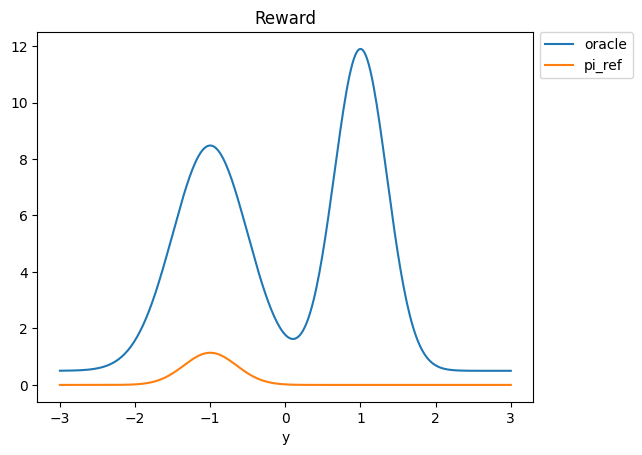

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

BT_SAMPLE = True

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def reward_function(y, offset=0.5):
    mean, std_dev = -1, 0.5
    component_1 = (1 / (np.sqrt(2 * np.pi * std_dev**2))) * np.exp(
        -0.5 * ((y - mean) / std_dev) ** 2
    )
    mean, std_dev = 1, 0.35
    component_2 = (1 / (np.sqrt(2 * np.pi * std_dev**2))) * np.exp(
        -0.5 * ((y - mean) / std_dev) ** 2
    )
    return 10 *(component_1 + component_2) + offset


def policy(y):
    mean, std_dev = pi_ref_mu, pi_ref_std
    return (1 / (np.sqrt(2 * np.pi * std_dev**2))) * np.exp(
        -0.5 * ((y - mean) / std_dev) ** 2
    )

n_sample_plot = 300
pi_ref_mu = -1
pi_ref_std = 0.35
y_plot = np.linspace(-3, 3, n_sample_plot)
r_plot = reward_function(y_plot)
pi_plot = policy(y_plot)

fig, ax = plt.subplots()
ax.plot(y_plot, r_plot, label="oracle")
ax.plot(y_plot, pi_plot, label="pi_ref")
ax.set_xlabel("y")
ax.set_title("Reward")
ax.legend(ncol=1, bbox_to_anchor=(1.2, 1), borderaxespad=0)

Text(0.5, 0, "y'")

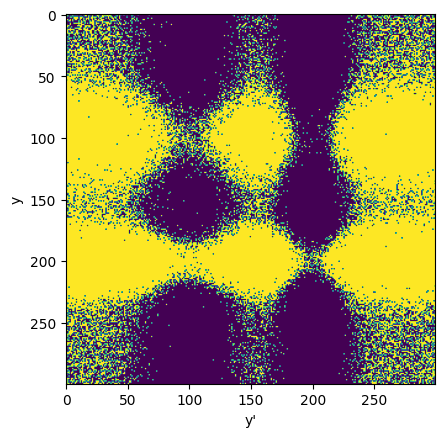

In [2]:
preference_landscape = np.zeros((n_sample_plot, n_sample_plot))
for i in range(n_sample_plot):
    for j in range(n_sample_plot):
        if BT_SAMPLE:
            z = np.random.binomial(1, p=sigmoid(reward_function(y_plot[i]) - reward_function(y_plot[j])))
            # z = reward_function(y_plot[i]) > reward_function(y_plot[j])
        else:
            z = reward_function(y_plot[i]) > reward_function(y_plot[j])
        preference_landscape[i, j] = z

plt.imshow(preference_landscape)
plt.ylabel("y")
plt.xlabel("y'")

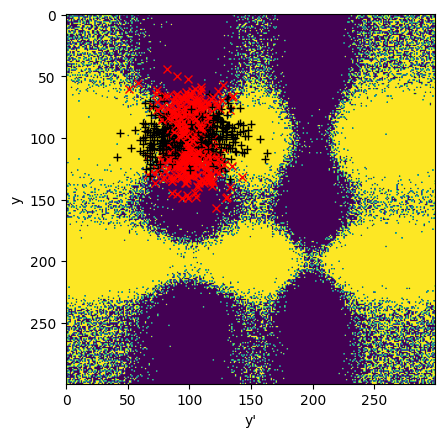

In [3]:
num_samples = 1000
y_pairs = np.random.normal(pi_ref_mu, pi_ref_std, (num_samples, 2))
# y_pairs = np.random.uniform(-3, 3, (num_samples, 2))
# y_pairs = np.concatenate([np.random.normal(1, 0.1, (300, 2)), np.random.uniform(-3, 3, (200, 2))])
z_pairs = reward_function(y_pairs[:, 0]) > reward_function(y_pairs[:, 1])

if BT_SAMPLE:
    z_pairs = np.array([np.random.binomial(1, p=sigmoid(reward_function(y_pairs[i, 0]) - reward_function(y_pairs[i, 1]))) for i in range(len(y_pairs))])
else:
    z_pairs = reward_function(y_pairs[:, 0]) > reward_function(y_pairs[:, 1])
map_coord = lambda x: (x + 3) / 6 * n_sample_plot
plt.imshow(preference_landscape)
plt.ylabel("y")
plt.xlabel("y'")
for i, (y, yp) in enumerate(y_pairs):
    if z_pairs[i]:
        label = "+"
        color = "black"
    else:
        label = "x"
        color = "red"
    plt.plot(map_coord(yp), map_coord(y), label, color=color)

In [4]:
from ellm.rm import model as backbone
import torch
from torch import optim
from ml_collections import ConfigDict

X = torch.from_numpy(y_pairs).float()
X_swap = torch.from_numpy(np.stack([y_pairs[:, 1], y_pairs[:, 0]], axis=-1)).float()
Y = torch.from_numpy(z_pairs)[:, None].float()

def get_model_pred(model, x):
    scores = model.model(x[None].repeat(model.model.num_ensemble, 1, 1))
    mean_scores = scores.mean(0)
    std_scores = scores.std(0)
    return mean_scores, std_scores


chosen_features = torch.where(Y == 1, X, X_swap)
rejected_features = torch.where(Y == 0, X, X_swap)
pair_features = torch.stack([chosen_features, rejected_features], dim=1).float()


model_cls = getattr(backbone, "EnnTSInfoMax")
model_cfg = ConfigDict(
    {
        "enn_max_try": 1,
        "num_ensemble": 20,
        "encoding_dim": 2,
        "rm_hidden_dim": 128,
        "rm_act_fn": "relu",
        "rm_lr": 1e-3,
        "rm_wd": 5e-5,
        "enn_lambda": 0.1,
        "exp_allow_second_best": False,
        "rm_sgd_steps": 1,
    }
)
model = model_cls(model_cfg)
from ellm.types import RewardData
from ellm.utils.buffer import UniformBuffer

batch = RewardData(
    pair_features=pair_features,
    loss_masks=torch.ones(len(pair_features)),
)
buffer = UniformBuffer(10000)
buffer.extend(batch)
print(batch.pair_features.shape)
print("buffer size", buffer.size)
buffer.total_num_queries = 32
model.train_bs = 32

num_epochs = 300
mean_trajectory = []
std_trajectory = []

xv, yv = np.meshgrid(y_plot, y_plot)
y_grid = np.stack([xv.reshape(-1), yv.reshape(-1)], axis=-1)
r_pred_mean, r_pred_std = get_model_pred(model, torch.from_numpy(y_grid).float())
r_pred_mean = r_pred_mean.squeeze().detach().numpy()
r_pred_std = r_pred_std.squeeze().detach().numpy()
mean_trajectory.append(r_pred_mean)
std_trajectory.append(r_pred_std)

for epoch in range(num_epochs):
    info = model.learn(buffer)
    if (epoch+1) % 10 == 0:
        print(epoch, info)
        r_pred_mean, r_pred_std = get_model_pred(model, torch.from_numpy(y_grid).float())
        r_pred_mean = r_pred_mean.squeeze().detach().numpy()
        r_pred_std = r_pred_std.squeeze().detach().numpy()
        mean_trajectory.append(r_pred_mean)
        std_trajectory.append(r_pred_std)

torch.Size([1000, 2, 2])
buffer size 1000
9 {'train/rm/loss_rew': tensor(0.6935), 'train/rm/loss_reg': tensor(2.7179e-06), 'train/rm/chosen_rewards': tensor(-0.0022), 'train/rm/rejected_rewards': tensor(-0.0016), 'train/rm/lambda': 0.1}
19 {'train/rm/loss_rew': tensor(0.6897), 'train/rm/loss_reg': tensor(5.0255e-06), 'train/rm/chosen_rewards': tensor(0.0029), 'train/rm/rejected_rewards': tensor(-0.0039), 'train/rm/lambda': 0.1}
29 {'train/rm/loss_rew': tensor(0.6857), 'train/rm/loss_reg': tensor(9.9409e-06), 'train/rm/chosen_rewards': tensor(0.0074), 'train/rm/rejected_rewards': tensor(-0.0076), 'train/rm/lambda': 0.1}
39 {'train/rm/loss_rew': tensor(0.6801), 'train/rm/loss_reg': tensor(1.8972e-05), 'train/rm/chosen_rewards': tensor(0.0145), 'train/rm/rejected_rewards': tensor(-0.0123), 'train/rm/lambda': 0.1}
49 {'train/rm/loss_rew': tensor(0.6519), 'train/rm/loss_reg': tensor(3.3912e-05), 'train/rm/chosen_rewards': tensor(0.0441), 'train/rm/rejected_rewards': tensor(-0.0428), 'train/

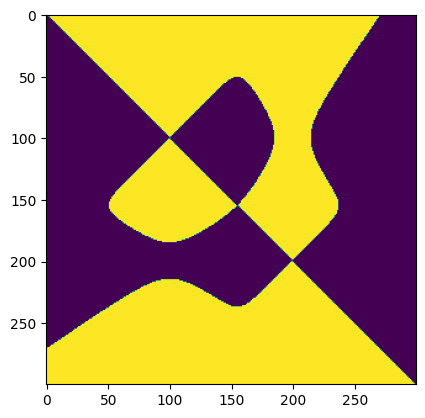

In [5]:
z_gt = reward_function(y_grid)[:,0] > reward_function(y_grid)[:,1]
plt.imshow(z_gt.reshape(n_sample_plot, n_sample_plot))

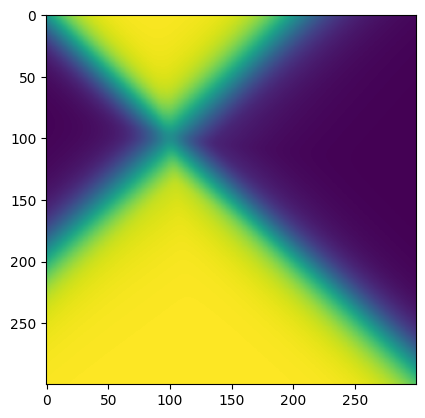

In [14]:
j = -1
img = torch.from_numpy(mean_trajectory[j].reshape(n_sample_plot, n_sample_plot)).sigmoid().numpy()
plt.imshow(img)

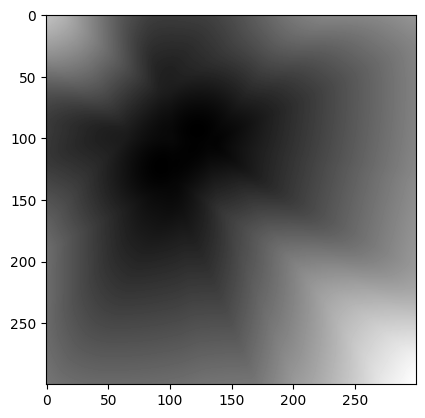

In [7]:
j = -1

uncertainty = std_trajectory[j].reshape(n_sample_plot, n_sample_plot)
uncertainty = (uncertainty - uncertainty.min()) / (uncertainty.max() - uncertainty.min())

_ = uncertainty < np.percentile(uncertainty, 10)

plt.imshow(uncertainty, cmap="gray")

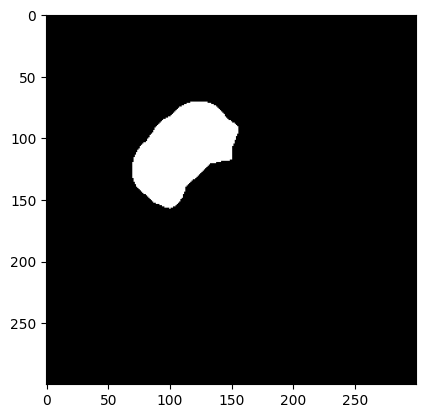

In [8]:
j = -1

uncertainty = std_trajectory[j].reshape(n_sample_plot, n_sample_plot)
uncertainty = (uncertainty - uncertainty.min()) / (uncertainty.max() - uncertainty.min())

_ = uncertainty < np.percentile(uncertainty, 5)

plt.imshow(_, cmap="gray")

In [9]:
scores = model.model(torch.from_numpy(y_grid).float()[None].repeat(model.model.num_ensemble, 1, 1))

In [13]:
scores.sigmoid()

tensor([[[0.7620],
         [0.7749],
         [0.7873],
         ...,
         [0.9585],
         [0.9568],
         [0.9550]],

        [[0.0152],
         [0.0167],
         [0.0184],
         ...,
         [0.9619],
         [0.9605],
         [0.9591]],

        [[0.9935],
         [0.9937],
         [0.9939],
         ...,
         [0.3440],
         [0.3271],
         [0.3107]],

        ...,

        [[0.1601],
         [0.1711],
         [0.1828],
         ...,
         [0.9583],
         [0.9571],
         [0.9558]],

        [[0.8956],
         [0.9013],
         [0.9067],
         ...,
         [0.6971],
         [0.6814],
         [0.6654]],

        [[0.1137],
         [0.1230],
         [0.1329],
         ...,
         [0.7721],
         [0.7580],
         [0.7435]]], grad_fn=<SigmoidBackward0>)

In [10]:
mu

NameError: name 'mu' is not defined

In [ ]:
mu

tensor([[0.0000, 0.0069, 0.0079,  ..., 0.3841, 0.3873, 0.3866],
        [0.0069, 0.0000, 0.0069,  ..., 0.3867, 0.3859, 0.3765],
        [0.0079, 0.0069, 0.0000,  ..., 0.3853, 0.3755, 0.3425],
        ...,
        [0.3841, 0.3867, 0.3853,  ..., 0.0000, 0.0058, 0.0066],
        [0.3873, 0.3859, 0.3755,  ..., 0.0058, 0.0000, 0.0058],
        [0.3866, 0.3765, 0.3425,  ..., 0.0066, 0.0058, 0.0000]])

In [ ]:
features = torch.from_numpy(y_plot).view(-1, 1, 1).float()
rewards = model._get_rewards(features).squeeze(-1).squeeze()
mean = rewards.mean(0).numpy()
std = rewards.std(0).numpy()

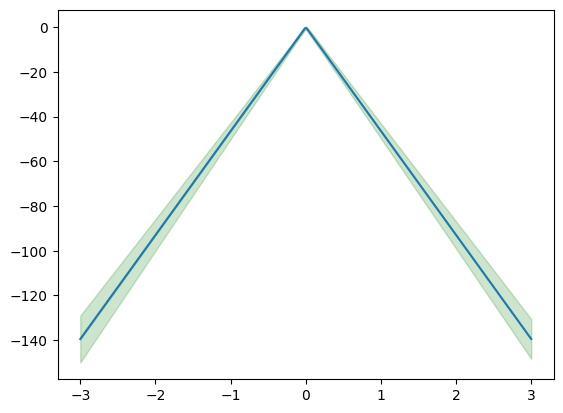

In [ ]:
plt.plot(y_plot, mean, label="pred_r")
plt.fill_between(y_plot, mean, mean + 2*std, color="green", alpha=0.2)
plt.fill_between(y_plot, mean - 2* std, mean, color="green", alpha=0.2)

In [ ]:
xv, yv = np.meshgrid(y_plot, y_plot)

array([[-3.        , -3.        ],
       [-2.97993311, -3.        ],
       [-2.95986622, -3.        ],
       ...,
       [ 2.95986622,  3.        ],
       [ 2.97993311,  3.        ],
       [ 3.        ,  3.        ]])